# Fourier Transforms

The [Fourier Transform](https://en.wikipedia.org/wiki/Fourier_transform) (see also [Fourier Transform](http://mathworld.wolfram.com/FourierTransform.html) on Wolfram) takes a function in _time_ space and transforms it to _frequency_ space. This turns out to be remarkably useful in many situations. The equivalent procedure is used in Quantum Mechanics to change basis between position and momentum space.

You will find that Fourier Transforms are useful in 505,701,702 for Quantum Mechanics, and in 605 for the analysis of analog circuits.

Note that the [Fourier Transform](https://en.wikipedia.org/wiki/Fourier_transform) is related to, but not identical to, the [Fourier Series](https://en.wikipedia.org/wiki/Fourier_series). We will look at the transform first, then look at the series.

Mathematically, we can define the [Fourier Transform](https://en.wikipedia.org/wiki/Fourier_transform) as:
$$
\begin{array}{lcl}
f(t) &=&\frac{1}{\sqrt{2\pi}} \int_{-\infty}^{\infty} F(\omega) e^{i \omega t} d\omega \\
F(\omega) &=& \frac{1}{\sqrt{2\pi}} \int_{-\infty}^{\infty} f(t) e^{-i \omega t} dt 
\end{array}
$$
Note that this is a physics-centric definition. Mathematicians would prefer:
$$
\begin{array}{lcl}
f(t) &=& \int_{-\infty}^{\infty} F(k) e^{i 2\pi  k t} dk \\
F(k) &=& \int_{-\infty}^{\infty} f(t) e^{-i 2\pi k t} dt 
\end{array}
$$

You can see that one is obtained from the other with the transformation $\omega = 2\pi k$, taking care that the normalization is adjusted to keep the equations symmetric.

Note that these transformation use complex numbers, and so the functions $f(t)$ and $F(\omega)$ or $F(k)$, are also considered complex. 

Since the Fourier transform is basically an integral, we already have the tools to do this using the integration we did in [Basic Calculus](https://github.com/mholtrop/Phys601/blob/master/Notebooks/04_Basic_Calculus.ipynb).

You will find that in general on a computer you are doing a [Discrete Fourier Transform](https://en.wikipedia.org/wiki/Discrete_Fourier_transform)(DFT), since you will be taking discrete steps in time (or frequency). For the Discrete Fourier Transform, there are a number of things to be careful about. First, we cannot integrate from $-\infty$ to $\infty$, instead, we integrate from 0 to $T$ (or $-T/2$ to $T/2$), and we have a stepsize of $\Delta T$. The [Nyquist theorem](https://en.wikipedia.org/wiki/Nyquist_frequency) tells us that with a stepsize of $\Delta T$, we can only have frequencies up to $\frac{1}{2\Delta T}$. We _do_ however get $N$ points in the _frequency domain_, with half the points representing negative frequencies. These negative frequencies are only needed if the input values to our DFT have complex terms. 

We use an array for the frequencies with $N$ points from 0 to $\frac{1}{\Delta T}$, with  $k = \left[0,\frac{1}{2\Delta T}\right]$ representing the positive frequencies, and $k=[\frac{1}{\Delta T},\frac{1}{2\Delta T}]$ representing the negative frequencies. Note that these are in reverse! 

We start with some function. To make sure we know the answer beforehand, we will use a function composed of three sines. Also, define some useful variables, $N=$the number of points, $T=$total time simulated, and $DT=$the sample spacing in time. We will have 20 seconds in time here, with 4096 points total on the t axis. 

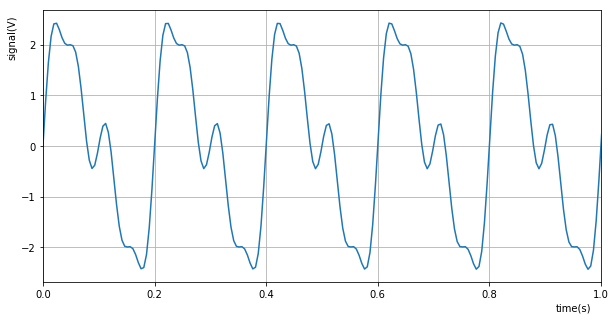

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
Freq = 5.
T = 20.     # The length of time determines the resolution of the FFT: how many bins per Hz.
N = 2**12  # The total number of points determines the resolution in time: bins per sec. 
            # This translates to the highest available frequency on the FFT
#N=  2**20 # In general FFTs go faster if you do them over 2 to the power N points.
DT = T/N
t = np.linspace(0,T,N)
y = 2.*np.sin(2*np.pi*Freq*t)+1.*np.sin(2*np.pi*2*Freq*t)++0.5*np.sin(2*np.pi*4*Freq*t)

plt.figure(figsize=(10,5))
plt.plot(t,y)
plt.grid(True)
plt.xlabel("time(s)",position=(0.95,1))
plt.ylabel("signal(V)",position=(1,0.9))
ax = plt.gca()
ax.set_xlim(0.,1.)
plt.show()

We now want to compute the transform using the integrals shown above. Here you should immediately notice that the integral method requires one integral _for each value_ of $\omega$. So for a transform with $N$ points in the input function, and $N$ points in the transform function, you need to do $N$ integrals, so $N^2$ operations. This can be time consuming. A faster method, the Fast Fourier Transform, is discussed below.

For this notebook I assume that instead of using the function, we have the more general situation where we have a set of datapoint, $y_k$. The _integral_ then becomes a _sum_ over these values.

$$
F(k) = \int_{0}^{T} f(t) e^{-i 2\pi k t} dt\qquad \Rightarrow\qquad F_i = \frac{1}{N} \sum_{n=0}^{N-1} y_n \exp{\left( -i 2\pi k_i t_n \right)} 
$$

The points at which we can evaluate $F(k)$ are _not_ arbitrary. As mentioned above, they depend on the range and step size of the time ($t$) points of our original funtion. We create an array, _freq_ from $0$ to $\frac{1}{\Delta T}$ with $N$ points, the same number as the time array. We can then step through this _freq_ array and evaluate the integral for each value. Doing this allows the use of Numpy and list comprehension to speed up computation. You could also do $k = \frac{i}{N\Delta T}$ and do $N$ steps in $i$.

The code is below:

In [2]:
F = np.zeros_like(t,dtype='complex')      # Create the output array for the result as complex numbers, same number of steps as t array.
#
# Commented out here is how you would use integrate.trapz()
# Note that that function only takes real values, so we have to split up the integral into 
# the real and imaginary component. Numpy.sum() avoids that complication.
#
# import scipy.integrate as integrate
# for i in range(len(omega)):               # Step through the omega array by index.
#    yy = y*np.exp( -(1j)*t*omega[i])    # Compute the result of f(t)*exp( -i*t*omega). Note: complex number i= 1j
#    F_real = integrate.trapz(np.real(yy),t) # Now integrate the real term of the array and store the result.
#    F_imag = integrate.trapz(np.imag(yy),t) # Integrate the imaginary term of the array and store result.
#    F[i]   = (F_real + 1j*F_imag)

#for i in range(N):               # Step through the omega array by index.
#    F[i] = np.sum(y*np.exp( -(1j)*t*i/N/DT) )/N      # Combine the real + i* imaginary and put in output array.
#
# This is the exact same loop of loops, but now using list comprehension.
#
freq = np.linspace(0,1/DT,N) # Create the array of k values (frequencies).
Fc = np.array([ np.sum(y*np.exp( -(2j)*np.pi*t*fi) )/N for fi in freq ])

We would like to plot this result. Note that we ended up with both the _negative_ and _positive_ frequencies in our $Fc$ array, and that the $Fc$ values are in general complex. The _interpretation_ of the $Fc$ array is that the _absolute value_ represents the _strength_ of the signal for that frequency. If the input values were all real, then we will have $Fc_{N-i} = Fc_{i}^*$. So to plot the signal strength, we need to add $|Fc{i}|$ to $|Fc{N-i}|$. If the input values are real, then this will be equal to $2|Fc{i}|$.

Below we first plot the entire range, so you can see both the positive and negative frequencies, and then below we plot $2|Fc{i}|$ for only a limited range, so you can see we recover the strengths of our input signal at the correct frequencies.

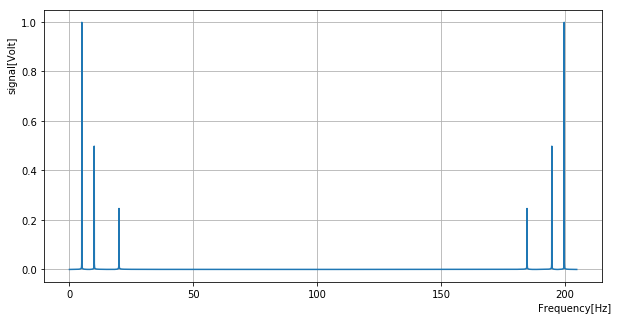

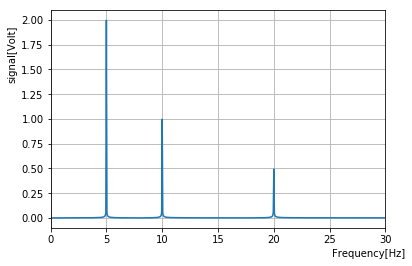

In [3]:
plt.figure(figsize=(10,5))
# freq = omega/(2*np.pi)      # We want to plot the frequency, not the angular frequency.
#plt.plot(freq,np.abs(F)) # You plot the absolute. The complex angle encodes a phase of the wave.
plt.plot(freq,np.abs(Fc))
plt.grid(True)
ax = plt.gca()
#ax.set_xlim(0,300)        # Zoom in: plot only from 0 to 30 Hz.
# plt.yscale("log")      # Uncomment these to get a log-y scale.
# ax.set_ylim(1e-4,1)
plt.xlabel("Frequency[Hz]",position=(0.95,1))
plt.ylabel("signal[Volt]",position=(1,0.8))
plt.show()
plt.plot(freq[0:N//2],np.abs(Fc[0:N//2])*2)
plt.grid(True)
ax = plt.gca()
ax.set_xlim(0,30)        # Zoom in: plot only from 0 to 30 Hz.
# plt.yscale("log")      # Uncomment these to get a log-y scale.
# ax.set_ylim(1e-4,1)
plt.xlabel("Frequency[Hz]",position=(0.95,1))
plt.ylabel("signal[Volt]",position=(1,0.8))
plt.show()

You can see that we recover the three frequencies, 5, 10 and 20 Hz, but the peaks have broadened due to the finite step size in time. 

We can now do the Inverse Discrete Fourier Transform (IDFT) in a similar way and recover the original wave form. An interesting fact here is that you will recover the _exact_ waveform. Even though you made finite steps, thus approximating the integrals, the IDFT still recovers the exact input waveform. (You can find a proof of this in for instance: "Computational Physics" by Mark Newman)

The integral for the IDFT takes the form:

$$
f(t) = \int_{-\infty}^{\infty} F(k) e^{i 2\pi  k t} dk\qquad \Rightarrow \qquad f_n = \sum_{i=0}^{N-1} F_i \exp{\left( i 2\pi k_i t_n \right)}
$$

There is a subtlety here in the normalization. You do _not_ divide by $N$. The reason is the orthonormality of the functions we use for the transform. (Again, you can find the proof elsewhere.)

In [4]:
f = np.zeros_like(t,dtype='complex') 
# Again, integrate.trapz() method commented out:
# for i in range(len(t)):               # Step through the omega array by index.
#    fy = F*np.exp( (1j)*omega*t[i])    # Compute the result of f(t)*exp( -i*t*omega). Note: complex number i= 0+1i
#    f_real = integrate.trapz(np.real(fy),omega) # Now integrate the real term of the array and store the result.
#    f_imag = integrate.trapz(np.imag(fy),omega) # Integrate the imaginary term of the array and store result.
#for i in range(len(t)):               # Step through the omega array by index.
#    f[i] = np.sum(F*np.exp((1j)*omega*t[i]))

f = np.array([np.sum(Fc*np.exp((2j)*np.pi*freq*ti)) for ti in t])

We plot the resulting function $f(t)$, and see that indeed the original wavefunction is exactly recovered. 

If you made a mistake, perhaps with the normalization, then you would not recover the original shape. Note that because we have $f_n$ values that are complex numbers, we need to take the real part in order to make the plot. We also plot the imaginary part to show these are indeed zero.

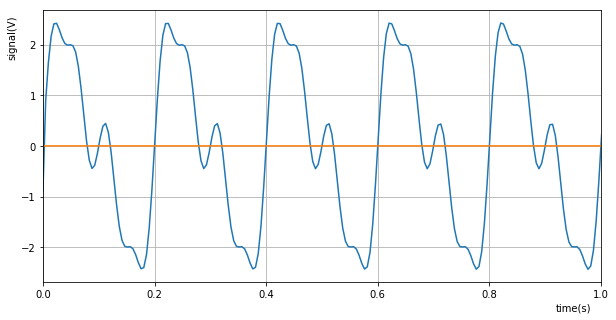

In [5]:
plt.figure(figsize=(10,5))
plt.plot(t,np.real(f))      # In this case, you plot the real term. 
plt.plot(t,np.imag(f))      # The imaginary term should be close to zero.
plt.grid(True)
plt.xlabel("time(s)",position=(0.95,1))
plt.ylabel("signal(V)",position=(1,0.9))
ax = plt.gca()
ax.set_xlim(0.,1.)
plt.show()

Note we did indeed get the same curve back as what we started with, and the complex terms are essentially zero.

# Fast Fourier Transforms, FFT, With Python

You may have noticed that the Fourier Transform is a slow computation. If you increase the number of points, it very quickly gets very slow. This is because an integral takes $N$ steps, where $N$ is the number of points in the array, and we need to do $N$ such integrals, so we do $N^2$ calculations. 

There is a much faster way to compute the Fourier Transform, called [Fast Fourier Transform](https://en.wikipedia.org/wiki/Fast_Fourier_transform)(FFT). This is a complicated algorithm that takes $N \log(N)$ steps instead of $N^2$ steps. On a computer, especially for large $N$, you always want to do an FFT. There are built in functions to do this.  

Here you will see how you can make Fast Fourier Transforms (FFT) using Python and SciPy. 
This is just a quick example tutorial, the real documentation is at:[scipy.fftpack](https://docs.scipy.org/doc/scipy-0.18.1/reference/tutorial/fftpack.html).

Import the needed libraries:

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft, fftfreq, fftshift, ifftshift

Again, define some useful variables, $N=$the number of points, $T=$total time simulated, and $DT=$the sample spacing in time. We will have 20 seconds in time here, with a 10001 points total on the t axis. We then create a linear space, i.e. a big array with evenly spaced numbers, each 0.002 apart. We show the first 5 elements of the array.

A note on these variable for an FFT. The variable $T$ The total number of points per second, $N/T$, will determine the largest possible frequency that the the simulation can show. The *Nyquist* frequency is defined as $F_N = \frac{N}{2T}$, is the very highest frequency that can be shown, essentially when every other point is a max or a min value. This concepts comes back when we are dealing with Analog to Digital Converters (ADCs). For the FFT, there will be an equal number of points in Frequency space as there will be in Time space, otherwise you would loose or gain information, which is not realistic. Since Frequency space goes from $[-F_N,+F_N]$, you can see that $T$ directly determines how many bins there are per Hz in frequency space. So, if you increase $N$, you will increase how nicely the sinewave is rendered in the Time domain, but you do not increase the resolution (number of bins per Hz) of the Frequency domain. To increase the number of bins in the Frequency domain, we need to increase $T$.

In [7]:
F = 5.
T = 20.     # The length of time determines the resolution of the FFT: how many bins per Hz.
            # The total number of points determines the resolution in time: bins per sec. 
            # This translates to the highest available frequency on the FFT
N=  2**20   # In general FFTs go faster if you do them over 2 to the power N points. 2**20 is A LOT of points!!!
DT = T/N
t = np.linspace(0.,T,N)
t[0:5]

array([0.00000000e+00, 1.90735045e-05, 3.81470090e-05, 5.72205136e-05,
       7.62940181e-05])

Now we want to create some kind of signal. In this case, 3 sine waves with frequencies F, 2F and 4F (5,10,20)Hz, and amplitudes of 2, 1 and 0.5 Volts. We create this signal simply using the sin function from numpy.

In [8]:
y = 2.*np.sin(2*np.pi*F*t)+1.*np.sin(2*np.pi*2*F*t)++0.5*np.sin(2*np.pi*4*F*t)

Let's make a plot of this signal, as it would show up on an osciloscope. We limit the time to 1 second, otherwise it gets very hard to see the actual shape of the wave.

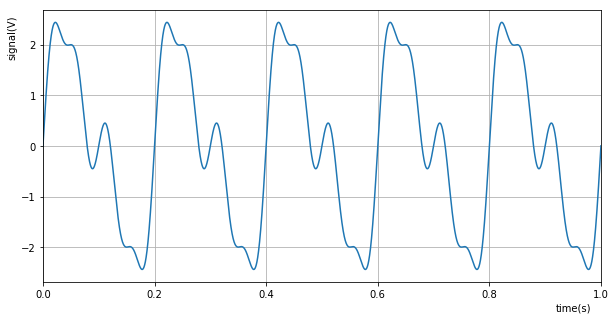

In [9]:
plt.figure(figsize=(10,5))
plt.plot(t,y)
plt.grid(True)
plt.xlabel("time(s)",position=(0.95,1))
plt.ylabel("signal(V)",position=(1,0.9))
ax = plt.gca()
ax.set_xlim(0.,1.)
plt.show()

We now want to see the Fourier Transform of this signal. We need to note a few important details though. First of all, we have a signal that lasts only from 0 to 2 seconds. The full Fourier Transform is defined from $-\infty$ to $+\infty$, so we don't *quite* get three infinitely narrow spikes, which is what we would expect. This issue has to do with the subtle bit of Fast Fourier Transforms called "windowing". Most of the time you can ignore this, if you accept that the window causes artifacts (i.e. the FFT will not perfectly go to zero in between the peaks.)

For the x axis, we use the handy fftfreq() function, which automatically creates the correct x-axis. 

The FFT will have negative and positive frequencies, which in this care are put in the array as [positive values,...,negative values]. This is how the algorithm works, but it doesn't work nice for plotting. The function fftshift() helps out by ordering the array from negative to positive values. In our case, with an input of real values, you only need the positive values of the FFT, so fftshift isn't strictly needed.

We also use ax.set_xlim to set the limit of the x-axis, since otherwise it goes from $-1/2T$ to $+1/2T$. We only need the interval from zero to 30 Hz to see all the signal.

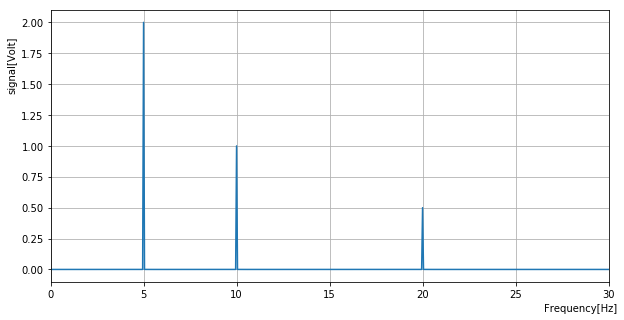

In [10]:
f_fft = fftshift(fftfreq(N,DT))  # Calculate the frequencies, and shift so that f=0Hz is in the center.
y_fft = fftshift(fft(y))         # Calculate the FFT, and also shift so that f=0Hz is in the center.
plt.figure(figsize=(10,5))
plt.plot(f_fft,2./N*np.abs(y_fft)) # Note: the 2./N properly normalizes the FFT amplitude to be in Volts.
plt.grid(True)
ax = plt.gca()
ax.set_xlim(0,30)        # Zoom in: plot only from 0 to 30 Hz.
# plt.yscale("log")      # Uncomment these to get a log-y scale.
# ax.set_ylim(1e-4,1)
plt.xlabel("Frequency[Hz]",position=(0.95,1))
plt.ylabel("signal[Volt]",position=(1,0.8))
plt.show()

Note that this all evaluated much faster than our previous algorithm, eventhough it used _a lot_ more points. Also note that by using more points, you got much narrower peaks in frequency space. They are nearly, but not quite, the delta function (single values) you would get with the full integral.

#### You try it:
Re-execute the code above with different values for N and note the widths of the peaks.

## Sawtooth and Square Wave functions

Now we will look at the FFT of a [square wave](https://en.wikipedia.org/wiki/Square_wave) signal, you can do the [sawtooth](https://en.wikipedia.org/wiki/Sawtooth_wave). 

You can compute a sawtooth with $f(t) = \mathrm{mod}(t,\Delta T)/\Delta T$, which gives a sawtooth signal of size 1, with a period $\Delta T$. You can turn this into a square wave by setting the condition $f(t) = 1, \mathrm{if}\ \mathrm{mod}(t,\Delta T)/\Delta T <0.5 , 0\ \mathrm{otherwise}$.

Using Numpy this is easily expressed as:

There is an excellent signal processing library for Python in SciPy called "signal", and it has a ready to go square wave form. See [scipy.signal](https://docs.scipy.org/doc/scipy-0.14.0/reference/signal.html). We will use that to create the waveform and then create the FFT. We will use the same frequency, F. The documentation states we need to multiply with $2\pi$ to get the correct normalization. The amplitude will be from -1 to 1.

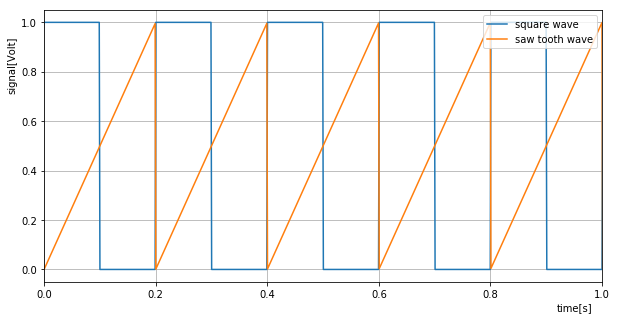

In [11]:
F = 5.
T = 20.     
N=  2**14   # In general FFTs go faster if you do them over 2 to the power N points. 2**20 is A LOT of points!!!
DT = T/N
t = np.linspace(0.,T,N)
y_sawtooth = np.mod(t,1/F)*F    # This creates the sawtooth with amplitude 1.
y_sq = 1*(y_sawtooth < 0.5)     # Turn the sawtooth into a square wave.
plt.figure(figsize=(10,5))
plt.plot(t,y_sq,label="square wave")
plt.plot(t,y_sawtooth,label="saw tooth wave")
plt.grid(True)
plt.legend(loc="upper right")
plt.xlabel("time[s]",position=(0.95,1))
plt.ylabel("signal[Volt]",position=(1,0.8))
ax = plt.gca()
ax.set_xlim(0,1)
plt.show()

Note that there is an excellent signal processing library for Python in SciPy called "signal", and it has a ready to go square wave form. See [scipy.signal](https://docs.scipy.org/doc/scipy-0.14.0/reference/signal.html). We will use that to create the waveform and then create the FFT. We will use the same frequency, F. The documentation states we need to multiply with $2\pi$ to get the correct normalization. The amplitude will be from -1 to 1. The code would be:
```
from scipy import signal
y_sq =0.5+0.5*signal.square(2*np.pi*F*t)
```

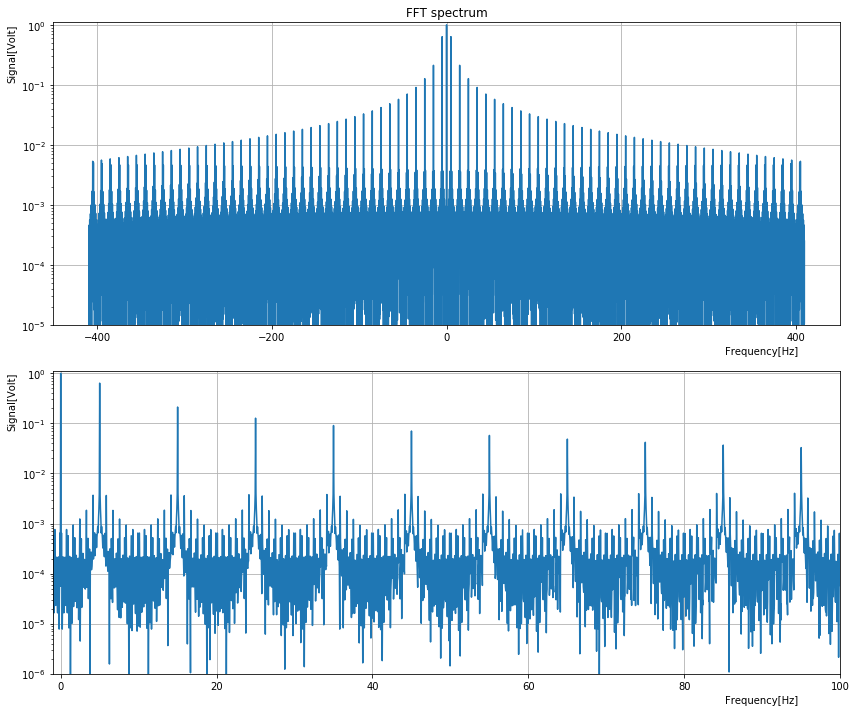

In [13]:
f_fft = fftshift(fftfreq(N,DT)) # Calculate the frequencies
y_sq_fft = fftshift(fft(y_sq)) # Compute the FFT, and shift it so that f=0Hz is at the center (plots better)
plt.figure(figsize=(12,10))
plt.subplot(2,1,1)
plt.semilogy(f_fft,2./N*np.abs(y_sq_fft)) # Plot log y and normalize by 2/N so spectrum is in Volt.
plt.grid(True)
ax = plt.gca()
#ax.set_xlim(0,100)
ax.set_ylim(1e-5,1.1)
plt.title("FFT spectrum")
plt.xlabel("Frequency[Hz]",position=(0.9,1))
plt.ylabel("Signal[Volt]",position=(1,0.9))
plt.subplot(2,1,2)                           # Plot again, but zoom in on the first 100 Hz.
plt.semilogy(f_fft,2./N*np.abs(y_sq_fft))
plt.grid(True)
ax = plt.gca()
ax.set_xlim(-1,100)
ax.set_ylim(1e-6,1.1)
plt.xlabel("Frequency[Hz]",position=(0.9,1))
plt.ylabel("Signal[Volt]",position=(1,0.9))
plt.tight_layout()          # Automatically adjust spacing between the 2 plots so they do not overlap
plt.show()

What we see is that the sharp edges of the square wave can only be made with really high frequencies. Also, note all the "noise" at low values $\approx 10^{-3}$, which should all be zero. They are not because of rounding errors in the computation and the

The shape of the FFT is exactly what you expect from Fourier Transforms theory of a square wave: an infinite series of spikes a distance of $2F$ apart, with diminishing amplitudes. The series is truncated in our case because of the limited time for the input signal. The log y-scale emphasizes the artifacts due to the windowing. They would diminish as we let $N\rightarrow\infty$.

We can take the FFT spectrum of our signal and do a reverse FFT to recover the original shape. Depending on the quality of the original FFT, the inverse may show artifacts. Try this by executing this notebook and changing the time span and/or number of points in the FFT and see how the FFT spectrum, and the inverse, change.

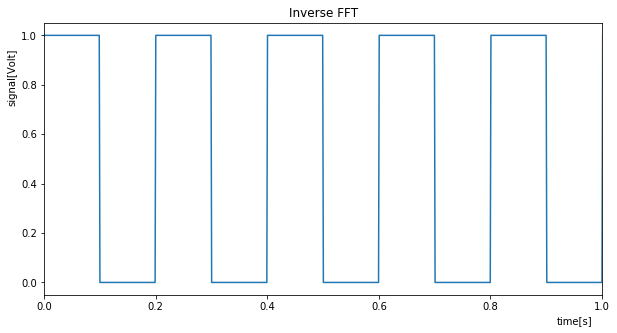

In [14]:
rev_fft = ifft(ifftshift(y_sq_fft))     # Un-shift the fft spectrum first.
plt.figure(figsize=(10,5))
plt.plot(t,np.abs(rev_fft))
plt.title("Inverse FFT")
plt.xlabel("time[s]",position=(0.95,1))
plt.ylabel("signal[Volt]",position=(1,0.8))
ax = plt.gca()
ax.set_xlim(0,1.)
plt.show()

#### You try it:
Try to compute the fourier transform for other input sequences: triangle waves and a wave packet.

### Filtering part of the FFT spectrum
You can use a numpy filter to select only part of the frequency spectrum and then do a reverse FFT on the result. Below you see what happens when we cut the frequencies at 40 Hz. This is done by multiplying the values of `y_sq_fft` by `np.abs(fft)<40.`. When the condition is true, the value is copied, when false, zero is copied. 

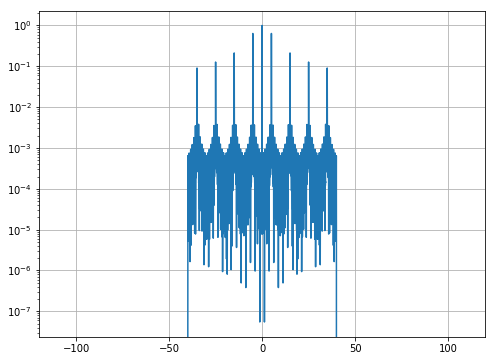

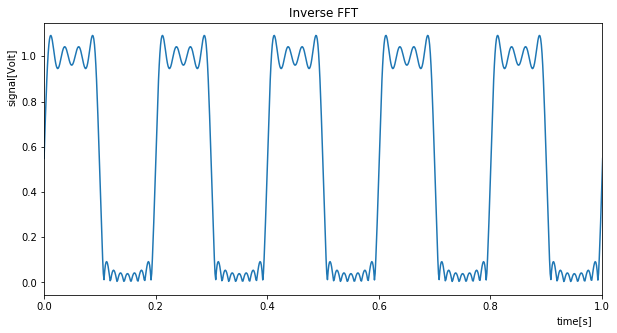

In [15]:
y_sq_fft_half = y_sq_fft*(np.abs(f_fft)<40.) # Only copy the values where freq < 40.
plt.figure(figsize=(8,6))                  # Plot to check
plt.semilogy(f_fft,2./N*np.abs(y_sq_fft_half)) # Plot log y and normalize by 2/N so spectrum is in Volt.
plt.xlim(-120.,120)
plt.grid(True)

rev_fft = ifft(ifftshift(y_sq_fft_half))     # Un-shift the fft spectrum first.
plt.figure(figsize=(10,5))
plt.plot(t,np.abs(rev_fft))
plt.title("Inverse FFT")
plt.xlabel("time[s]",position=(0.95,1))
plt.ylabel("signal[Volt]",position=(1,0.8))
ax = plt.gca()
ax.set_xlim(0,1.)
plt.show()

# Fourier Series
The [Fourier Series](https://en.wikipedia.org/wiki/Fourier_series) is a special case of the Fourier Transform to represent a periodic (i.e. repeating) signal. The signal is supposed to repeat in some specific interval, i.e. $[-\pi,pi]$, or $[L_1,L_2]$. In those cases, you can represent the function (or the data) as a sum over $\sin$ and $\cos$ terms. The mathematical statement is:

$$\begin{array}{lcl}
f(x) &=& \frac{1}{2} a_0 + \sum_{k=1}^{\infty} a_k \cos\left(\frac{2\pi k x}{\Delta L}\right) + \sum_{k=1}^{\infty} b_k \sin\left(\frac{2\pi k x}{\Delta L}\right)  \\
a_0 &=& \frac{1}{\Delta L} \int_{L_1}^{L_2} f(x) dx \\
a_k &=& \frac{2}{\Delta L} \int_{L_1}^{L_2} f(x) \cos\left(\frac{2\pi k x}{\Delta L}\right) dx \\
b_k &=& \frac{2}{\Delta L} \int_{L_1}^{L_2} f(x) \sin\left(\frac{2\pi k x}{\Delta L}\right) dx 
\end{array}
$$ 
where $\Delta L = L_2 - L_1$

Using Euler's formula: $e^{i\phi} = \cos(\phi) + i\sin(\phi)$, with a change of variables, we can re-cast these equations into a more general form, using complex numbers and complex coefficients:

$$
f(x) = \sum_{k=-\infty}^{\infty} \gamma_k e^{i\frac{2\pi k x}{\Delta L}}
$$
$$
\gamma_k = \frac{1}{\Delta L}\int_{L_1}^{L_2} f(x)e^{ -i\frac{2\pi k x}{\Delta L}} dx
$$

$$
\gamma_k = \left\{\begin{array}{ll}\frac{1}{2}(a_{-k} + ib_{-k} ) & \mathrm{if}\ k<0, \\
a_0                            & \mathrm{if}\ k=0, \\
\frac{1}{2}(a_{-k} + ib_{-k} ) & \mathrm{if}\ k>0.
\end{array}   \right.
$$

Any well behaved function $f(x)$ can be expanded this way. (In Quantum Mechanics you will learn that sine and cos are not the only expansion possibilities. This works for any _complete set of orthogonal functions_). In the re-written form, you can see that the Fourier Series is closely related to the Fourier Transform, with $ nx/\Delta L = n\Delta t = t$, and the integral replaced by a summation. Since a numerical Fourier Transform would have a summation for the integral anyway, the difference between the two is becomes only a scaling of the axes. 

You usually need to only calculate a few terms of the Fourier Series. In those cases the advantage of doing an a full FFT is not so great, and mathematically a direct computation of the terms may be more clear.

Note: You will sometimes see the Fourier series with different limits, going from $-L$ to $L$, or 0 to $2L$, with the $2\pi k x$ replaced with $\pi k x$. The result is that you will not have the factor of 2 in the integrals for the $a_k$ and $b_k$ terms.

When you are doing a Fourier Series over a set of _data_ rather than a function, the function $f(x)$ must be replaced by $N$ _data points_ $y_n$, and the integrals become sums. We now need to be careful with the normalization. The sample points for the integral are now: $x_n = \frac{n L}{N}$. If the function is periodic so that $f(0) = f(L)$, the integral for finding the coefficents becomes:

$$\begin{array}{lcl}
a_0 &=& \frac{1}{N} \sum_{n=0}^{N-1} y_n \\
a_k &=& \frac{2}{N} \sum_{n=0}^{N-1} y_n \cos\left(\frac{2\pi k n}{N}\right)\\
b_k &=& \frac{2}{N} \sum_{n=0}^{N-1} y_n \sin\left(\frac{2\pi k n}{N}\right)\\
\gamma_k &=& \frac{1}{N} \sum_{n=0}^{N-1} y_n \exp\left(-i \frac{2 \pi k n}{N} \right)
\end{array}
$$ 

Even though these are expressed as explicit sums, you can use np.sum() to do them more quickly.

There isn't really a _reverse_ Fourier Series. The coefficients you find allow you to approximate the function $f(x)$. The approximated function is then:

$$
f(x) = \frac{1}{2} a_0 + \sum_{k=1}^{\infty} a_k \cos\left(\frac{2\pi k x}{\Delta L}\right) + \sum_{k=1}^{\infty} b_k \sin\left(\frac{2\pi k x}{\Delta L}\right)
$$

**A note about the scale of the x-axis:** One detail that can be confusing is the _scale_ used for the x-axis. In the sums above, the $x$ parameters has disappeared, which is correct. The coefficients actually do not depend on the scale of the x-axis, they just depend on where you are in the first period of the wave. Thus changing the lenght of this period (the wave _and_ the integrals) only changes the scale of the x-axis. 

If you want to plot the result over more than one period, you want to still do the integrals over _one_ period. Anything longer (N times the period) will just cause all the coefficients to shift and give you lots of zero coefficients. For a 2 period integral, every other coefficient will be zero.

You _can_ of course plot the resulting function for as many periods as you would like, just evaluate the last equation over a larger range.

#### You try it:
Compute the first 5 terms for a saw-tooth shape wave with direct computation, and plot the terms. See: https://www.desmos.com/calculator/lab9nylxsi for the expected output.